In [1]:
#STEP-1 — Load the labeled dataset
import pandas as pd

df = pd.read_csv("data/india_states/labeled_dataset.csv")
print("Rows:", len(df))
df.head()

Rows: 953755


,location_id,location_name,sensor_id,parameter_original,parameter_display,value,unit,datetime_utc,datetime_local,latitude,...,parameter_so2,parameter_temperature,parameter_wind_direction,parameter_wind_speed,near_road,near_industry,near_farmland,near_landfill,near_dumpyard,pollution_source
0,17,"R K Puram, Delhi - DPCC",12234784,no2,NO₂,110.20,ppb,2025-11-24 13:00:00+00:00,2025-11-24T18:30:00+05:30,28.563262,...,False,False,False,False,1,0,0,0,1,Natural / Background
1,17,"R K Puram, Delhi - DPCC",12234782,co,CO,3.85,ppb,2025-11-24 13:00:00+00:00,2025-11-24T18:30:00+05:30,28.563262,...,False,False,False,False,1,0,0,0,1,Waste-Burning
2,17,"R K Puram, Delhi - DPCC",12234790,temperature,Temperature (C),17.50,c,2025-11-24 13:00:00+00:00,2025-11-24T18:30:00+05:30,28.563262,...,False,True,False,False,1,0,0,0,1,Natural / Background
3,17,"R K Puram, Delhi - DPCC",12234788,relativehumidity,RH,78.00,%,2025-11-24 13:00:00+00:00,2025-11-24T18:30:00+05:30,28.563262,...,False,False,False,False,1,0,0,0,1,Natural / Background
4,17,"R K Puram, Delhi - DPCC",12234789,so2,SO₂,3.50,ppb,2025-11-24 13:00:00+00:00,2025-11-24T18:30:00+05:30,28.563262,...,True,False,False,False,1,0,0,0,1,Natural / Background


In [2]:
#STEP-2 — Select Features + Target
y = df['pollution_source']
#Choose useful features
feature_cols = [
    'value', 'hour', 'month', 'weekday',
    'recent_spike','pm_trend_mean_3h','pm_trend_mean_6h',
    'near_road','near_industry','near_farmland','near_dumpyard','near_landfill',
    'latitude','longitude'
]

X = df[feature_cols]

#STEP-3 — Encode Target Labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_map)

#STEP-4 — Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

#STEP-5 — Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    class_weight="balanced"   # helps if some classes are smaller
)

model.fit(X_train, y_train)

Label mapping: {'Agricultural Burning': 0, 'Industrial': 1, 'Natural / Background': 2, 'Vehicular': 3, 'Waste-Burning': 4}


RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=300,
                       random_state=42)

                      precision    recall  f1-score   support

Agricultural Burning       0.46      0.99      0.63      1073
          Industrial       0.67      0.95      0.78     37008
Natural / Background       0.99      0.78      0.87    129872
           Vehicular       0.61      0.93      0.74     18445
       Waste-Burning       0.75      0.99      0.85      4353

            accuracy                           0.83    190751
           macro avg       0.70      0.93      0.77    190751
        weighted avg       0.88      0.83      0.84    190751



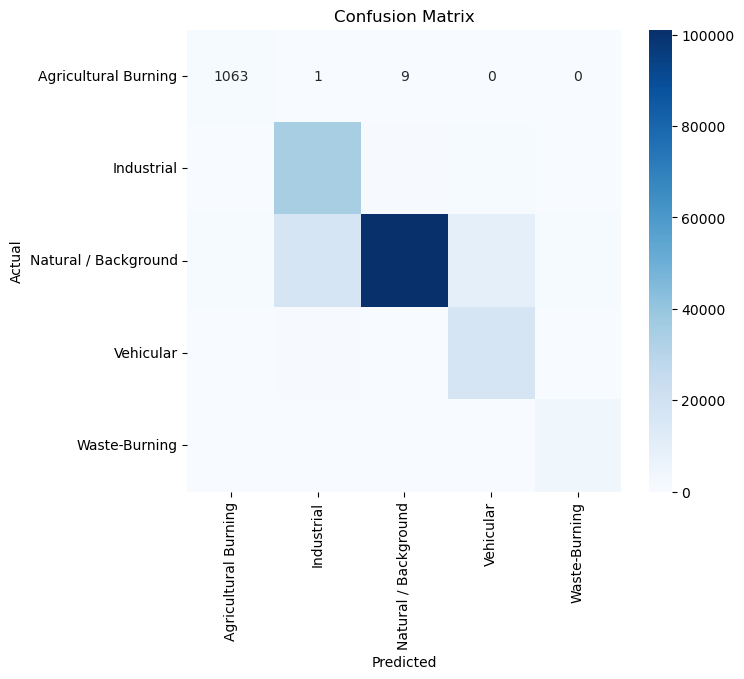

In [3]:
#STEP-6 — Evaluate the Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<Axes: title={'center': 'Feature Importance'}>

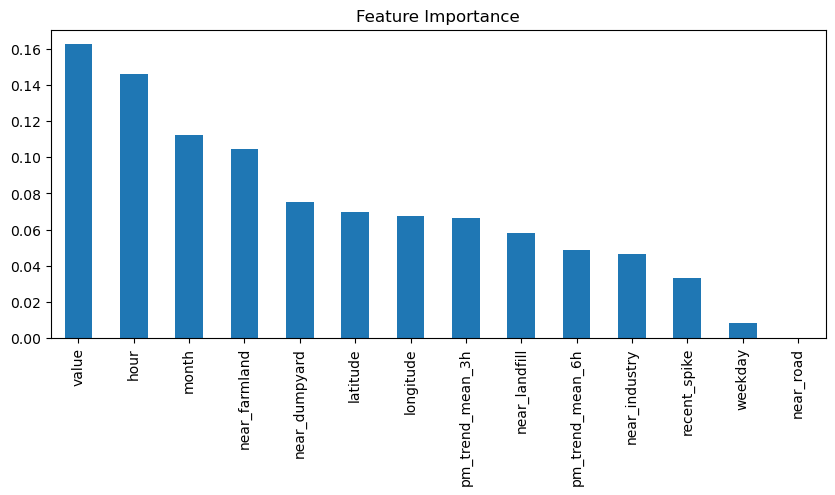

In [4]:
#STEP-7 — Feature Importance (Explainability)
import numpy as np

importances = model.feature_importances_
feat_importance = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
feat_importance
feat_importance.plot(kind='bar', figsize=(10,4), title="Feature Importance")

In [5]:
import os
os.makedirs("models", exist_ok=True)

In [6]:
#STEP-8 — Save Model for Dashboard Use
import joblib

joblib.dump(model, "models/source_classifier_rf.pkl")
joblib.dump(le, "models/label_encoder.pkl")

print("Model saved successfully")

Model saved successfully


In [7]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 83.23%


# Model tuning

In [11]:
df_sample = df.sample(frac=0.10, random_state=42)   # use 10% of data

X_small = df_sample[feature_cols]
y_small = le.transform(df_sample['pollution_source'])

In [13]:
from sklearn.model_selection import train_test_split

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42, stratify=y_small
)

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, class_weight="balanced")

param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,      # ✨ only 5 combinations
    cv=2,          # ✨ 2-fold CV
    n_jobs=-1,
    scoring='f1_macro',
    verbose=1
)

rand_search.fit(X_train_s, y_train_s)

print(rand_search.best_params_)
best_model = rand_search.best_estimator_

Fitting 2 folds for each of 5 candidates, totalling 10 fits
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


In [17]:
best_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       random_state=42)

In [19]:
y_pred = best_model.predict(X_test)


Accuracy: 96.97%

Classification Report:
                      precision    recall  f1-score   support

Agricultural Burning       0.92      0.97      0.95      1073
          Industrial       0.93      0.97      0.95     37008
Natural / Background       0.99      0.97      0.98    129872
           Vehicular       0.93      0.97      0.95     18445
       Waste-Burning       0.95      0.98      0.96      4353

            accuracy                           0.97    190751
           macro avg       0.94      0.97      0.96    190751
        weighted avg       0.97      0.97      0.97    190751



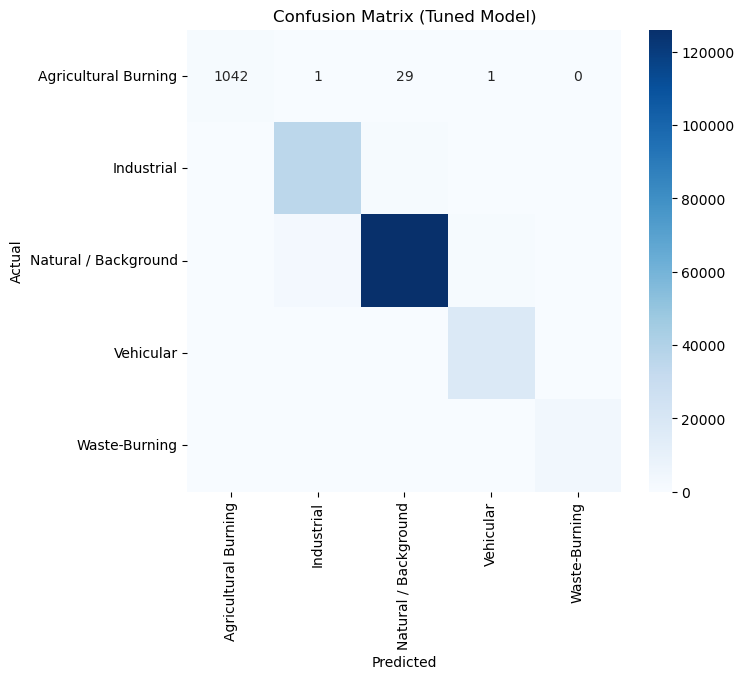

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predictions from tuned model
y_pred = best_model.predict(X_test)

# ===== Accuracy =====
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%\n")

# ===== Performance Matrix (Precision, Recall, F1) =====
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ===== Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Tuned Model)")
plt.show()

In [23]:
import joblib, os
os.makedirs("models", exist_ok=True)

joblib.dump(best_model, "models/source_classifier_rf_tuned.pkl")
joblib.dump(le, "models/label_encoder.pkl")

['models/label_encoder.pkl']